## Hardware Implementation on PYNQ-Z2

In [1]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from qonnx.core.datatype import DataType
from driver_base import FINNExampleOverlay
from PIL import Image

## Define input parameters

In [2]:
build_dir = "final_results"
bitfile = f"../bitfile/finn-accel.bit"
platform = "zynq-iodma"
batch_size = 1
runtime_weight_dir = f"./{build_dir}/runtime_weights/"

io_shape_dict = {
    # FINN DataType for input and output tensors
    "idt" : [DataType['INT8']],
    "odt" : [DataType['INT8']],
    # shapes for input and output tensors (NHWC layout)
    "ishape_normal" : [(1, 1, 128, 1)],
    "oshape_normal" : [(1, 2)],
    # folded / packed shapes below depend on idt/odt and input/output
    # PE/SIMD parallelization settings -- these are calculated by the
    # FINN compiler.
    "ishape_folded" : [(1, 1, 128, 1, 1)],
    "oshape_folded" : [(1, 2, 1)],
    "ishape_packed" : [(1, 1, 128, 1, 1)],
    "oshape_packed" : [(1, 2, 1)],
    "input_dma_name" : ['idma0'],
    "output_dma_name" : ['odma0'],
    "number_of_external_weights": 0,
    "num_inputs" : 1,
    "num_outputs" : 1,
}


## Load the HW Accelerator

In [3]:
%%time
accel = FINNExampleOverlay(
        bitfile_name = bitfile, platform = platform,
        io_shape_dict = io_shape_dict, batch_size = batch_size,
        runtime_weight_dir = runtime_weight_dir
    )

CPU times: user 2.21 s, sys: 388 ms, total: 2.6 s
Wall time: 3.04 s


In [5]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal()), str(accel.idt())))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal()), str(accel.odt())))

Expected input shape and datatype: (1, 1, 128, 1) INT8
Expected output shape and datatype: (1, 2) INT8


In [6]:
# arr_folder = "val_data/0"
# nsr_folder = "val_data/1"
# arr_folder = "ecgdata/test_data/0/"
# nsr_folder = "ecgdata/test_data/1/"
arr_folder = "last_val_data/0/"
nsr_folder = "last_val_data/1/"

arr_files = os.listdir(arr_folder)
arr_images = [np.load(os.path.join(arr_folder,file)) for file in arr_files]

nsr_files = os.listdir(nsr_folder)
nsr_images = [np.load(os.path.join(nsr_folder,file)) for file in nsr_files]

test_imgs = np.concatenate((arr_images,nsr_images))
test_labels = np.concatenate((np.zeros(len(arr_images)),np.ones(len(nsr_images))))


In [7]:
test_imgs.shape

(3073, 1, 1, 128)

## Plot Images of both classes

Processing folder: Normal Sinus Rhythm


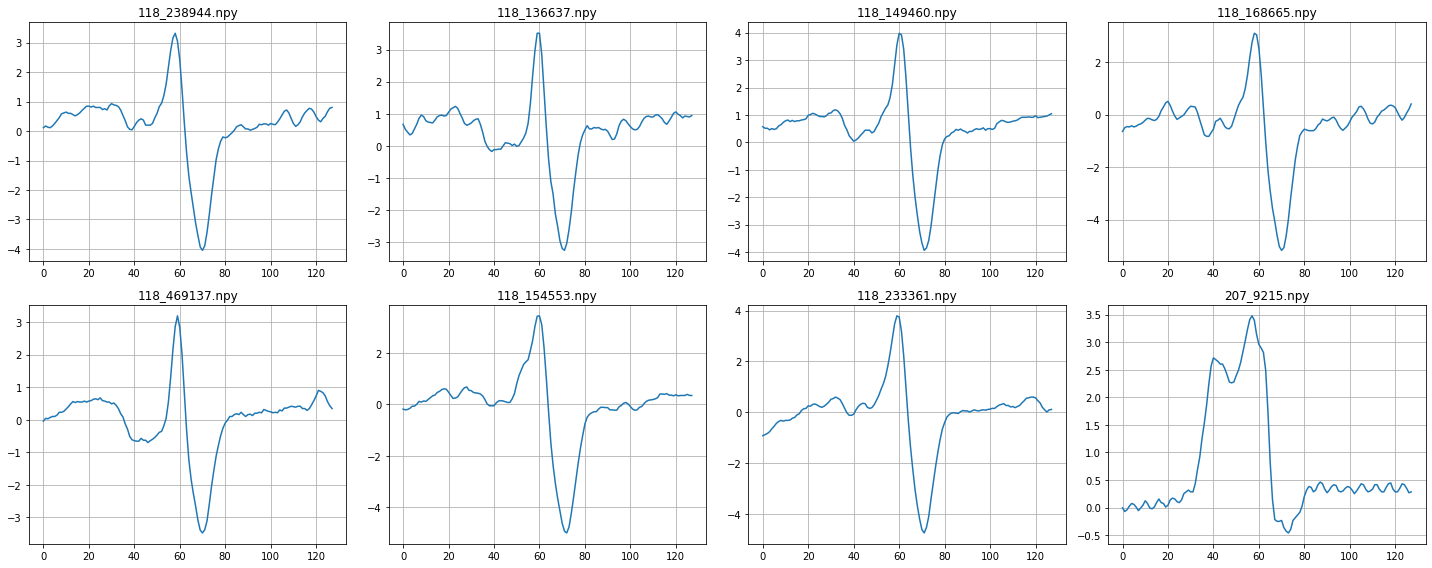

Processing folder: Atrial Flutter


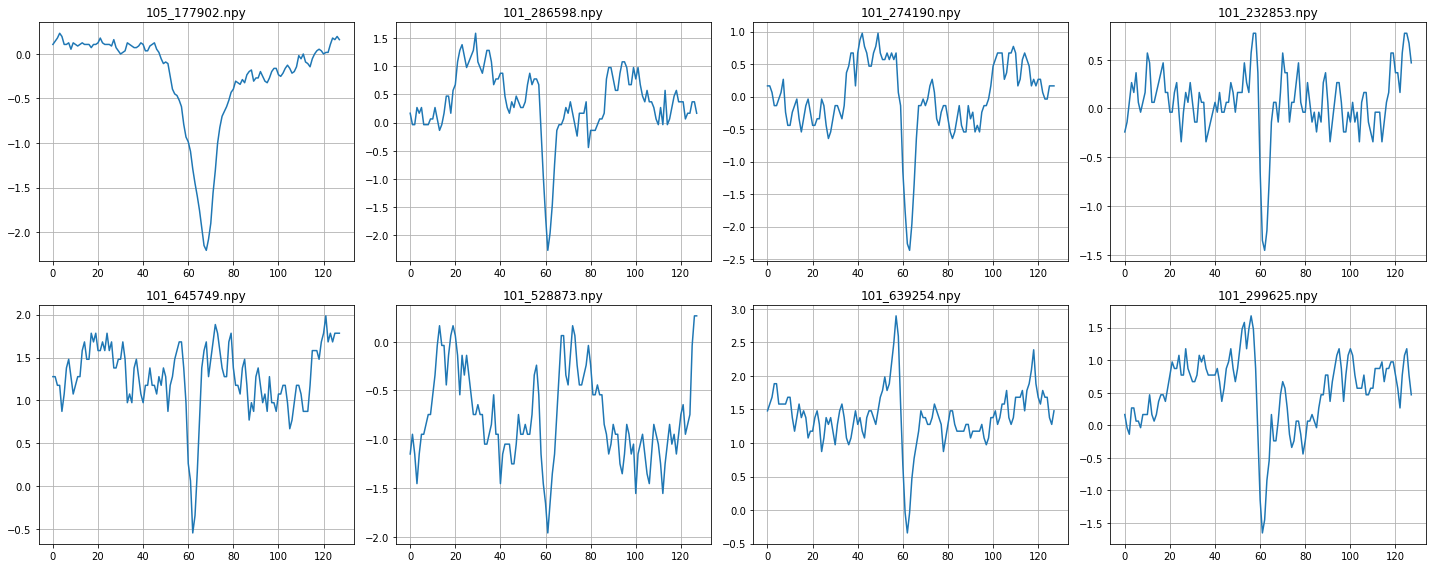

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_npy_files(folder_path):

    npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')][:8] #Plots 8 from each folder
    num_files = len(npy_files)
    num_cols = min(num_files, 4)
    num_rows = (num_files + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))
    
    if num_rows == 1:
        axes = [axes]
    
    for idx, file_name in enumerate(npy_files):
        row_idx = idx // num_cols
        col_idx = idx % num_cols
        file_path = os.path.join(folder_path, file_name)
        
        data = np.load(file_path)
        data = (np.squeeze(data))
        data = np.flip(data,axis = 0)
        
        axes[row_idx][col_idx].plot(data)
        axes[row_idx][col_idx].set_title(file_name)
        axes[row_idx][col_idx].grid(True)

    plt.tight_layout()
    plt.show()

def iterate_subfolders(root_folder):
    map = {root_folder+"0":"Atrial Flutter",root_folder+"1":"Normal Sinus Rhythm"}
    subfolders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(root_folder, subfolder)
        print("Processing folder:", map[subfolder_path])
        plot_npy_files(subfolder_path)


root_folder = 'ecgdata/test_data/'
iterate_subfolders(root_folder)

## Classify single image and measure time taken 

In [9]:
test_single_x = test_imgs[0]
test_single_y = test_labels[0]

map = {0: 'arr',1: 'nsr'}

print(f"Expected class is {map[test_single_y]}")


Expected class is arr


In [10]:
accel_in_test = test_single_x.reshape(accel.ishape_normal()).astype(np.int8)

map = {0: 'arr',1: 'nsr'}

start = time.time()
accel_out_test = accel.execute(accel_in_test)
total = time.time() - start

print(accel_out_test)

print(f"Returned classs is {map[np.argmax(accel_out_test[0])]}")
print("Inference time taken for single image on FPGA: {:.4f} seconds".format(total))

[[ 127. -128.]]
Returned classs is arr
Inference time taken for single image on FPGA: 0.0062 seconds


## Measure Validation Accuracy on FPGA

In [11]:
%%time
#     directory = f"ecgdata/train_data/{idx}/"
#     directory = f"val_data/{idx}/"

map = {0: 'Atrial Flutter',1: 'Normal Sinus Rhythm'}
total_correct = 0
total_length = 0

y_true = []
y_pred = []

for idx in range(0,2):
    directory = f"last_val_data/{idx}/"
    file_list = os.listdir(directory)
    correct = 0
    for file in file_list:
        ibuf_normal = np.load(directory+file)

        ibuf_normal = ibuf_normal.reshape(accel.ishape_normal()).astype(np.int8)

        obuf_normal = accel.execute(ibuf_normal)
#         print(obuf_normal.argmax() , idx)
#         print(obuf_normal)

        y_true.append(idx)
        y_pred.append(obuf_normal.argmax())
        
        if obuf_normal.argmax() == idx:
            correct += 1
            
    print(f"Class: {map[idx]}, Accuracy: {100 * correct/(len(file_list))} %, ({correct}/{len(file_list)})")
    total_correct += correct
    total_length += len(file_list)
print(f"Total Accuracy: {100 * total_correct/(total_length)} %, ({total_correct}/{total_length})")

Class: Atrial Flutter, Accuracy: 95.48 %, (2387/2500)
Class: Normal Sinus Rhythm, Accuracy: 94.06631762652705 %, (539/573)
Total Accuracy: 95.21640091116173 %, (2926/3073)
CPU times: user 16.9 s, sys: 661 ms, total: 17.6 s
Wall time: 17.6 s


## Plot Confusion Matrix 

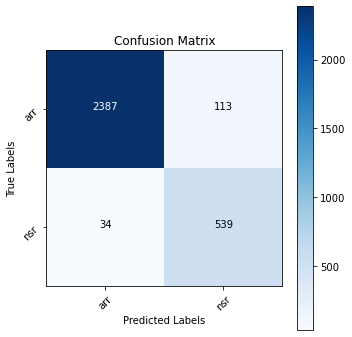

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix(y_true,y_pred,num_classes):
    cm = np.zeros((num_classes,num_classes),dtype = np.int32)
    
    for true_label, pred_label in zip(y_true,y_pred):
        cm[true_label][pred_label] += 1 
    
    return cm

def plot_confusion_matrix(cm,class_names):
    plt.figure(figsize=(5,5))
    plt.imshow(cm,interpolation='nearest',cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks,class_names,rotation=45)
    plt.yticks(tick_marks,class_names,rotation=45)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j,i,format(cm[i,j],fmt),horizontalalignment = "center",color = "white" if cm[i,j] > thresh else "black")
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    
    
cm = confusion_matrix(y_true,y_pred,2)
class_names = ['arr','nsr']

plot_confusion_matrix(cm,class_names)
plt.show()

## Throughput and Latency Measurements

In [13]:
import time
num_iterations = 100
ibuf_normal = np.load('val_data/0/101_100722.npy')
ibuf_normal = ibuf_normal.reshape(accel.ishape_normal()).astype(np.int8)

def benchmark_fpga(driver):
    total_time = 0.0
    for _ in range(num_iterations):
        start_time = time.time()
        obuf_normal = accel.execute(ibuf_normal)
        end_time = time.time()
        total_time += end_time - start_time
    
    latency = total_time / num_iterations
    throughput = num_iterations / total_time
    
    return latency, throughput

fpga_latency, fpga_throughput = benchmark_fpga(accel)

print("FPGA Latency:", fpga_latency, "seconds")
print("FPGA Throughput:", fpga_throughput, "inferences per second")


FPGA Latency: 0.0018994951248168946 seconds
FPGA Throughput: 526.4556812676194 inferences per second


## Reset Accelerator

In [ ]:
del accel

In [ ]:
%%time
#Execution Test

outputfile = "output.npy"
ibuf_normal = []

ibuf_normal.append(np.load("val_data/0/101_100722.npy").reshape(accel.ishape_normal()).astype(np.int8))

obuf_normal = accel.execute(ibuf_normal)
print(obuf_normal)
if not isinstance(obuf_normal, list):
    obuf_normal = [obuf_normal]
for o, obuf in enumerate(obuf_normal):
    np.save(outputfile[o], obuf)

In [ ]:
%%time
# Throughput test
accel.batch_size = 1
accel.throughput_test()

In [ ]:
%%time
accel.batch_size = 1
accel.latency_test(1000)